# Simple Moving Average strategy 
  By Devansh Gupta

## Disclaimer 
I am not a financial advisor and any findings in this research paper is not financial advice. Short term trading involves a lot of capital risk.

## Introduction and Pre-Analysis
In this research segment we will be looking at a automated trading strategy. The main premise is that a python script can scrape the internet for any stock profile, apply a strategy and make buy and sell decisions accordingly. This allows a trader to trade and make profits in multiple stocks at once (given the appropriate amount of capital) without having to manually place buy and sell orders for each one of them. 

In trading scenarios with intervals of 1 day (each candle) also known as swing trading, or with intervals of 1 minute (each candle) also known as intraday trading, it is crucial to keep a close watch on the price movements since they will be quite volatile, and also for a human it may be difficult to accurately grasp opportunites (price break-outs) in multiple stocks at once. To contrast, the opposite to this would be long term trading that spans of several months or years and requires deep and detailed company analysis to forecast returns. Therefore, this method is to be implemented to watch multiple stocks at once and streamline returns without much human intervention in a short term setting.

This strategy is meant to be run in a live market with live data entries, for testing purposes we will be using historical data from January 2021 to the present day. It also does not account for the type of industry or any other details of the company, the choice of test data is completely random.

In this assignment, any stock code (example GOOG for Google) can be entered with the function <code>pnl_plot_data('stock code')</code> to get results provided that the Yahoo servers are functional. If the plot diagrams display a message 'data taken from local CSV' then this will not be possible. Please feel free to try any stock code that is available on the Yahoo finance website to see returns.

## Strategy Explaination
Some important terminolgy:

MA10 - 10 day moving average. <br>
MA20 - 20 day moving average. <br>
Crossover - When the MA10 cuts the MA20 from below to above the MA20 line. <br>
Crossunder - When the MA10 dips below the MA20 from above the MA20 line. <br>
Market Open Price - The price at which the stock starts at in a new day (or new minute, depends on interval). <br>
Buy Price - Price at which the software has decided to buy the stock. <br>
Sell Price - Price at which the software has decided to sell the stock. <br>

The script first calculates MA10 and MA20 and adds it to the dataframe. It then searches for a crossover in the data to take the decision to buy the stock (only one share is bought, profit/loss is calculated in percentage later). It then searches for the next crossunder and takes a decision to sell.

In both these scenarios, when a crossover occurs it locks in a Buy Price at the next candle's market open price, when a crossunder occurs it locks in the opening price at the same candle it was checking (sell as soon as cross under detected). This is done to mimic a real world live trading situation. A marker will be placed and color coded (green for buy, red for sell) on the plotted graph.

A Profit/Loss percentage will only be produced in scenarios with an even number of Buy + Sell orders. 

There are many more attributes that contribute to stock trading, for example an analysis of the overall shape of the price-movements that helps determine if the strategy will be affective or not, however it would be too complex and i will not be analysing it

## Python imports 
Packages for handling and plotting data. 
For this code to run, please install the following libraries: <br>
pandas <br>
time <br>
datetime <br>
requests_html <br>
mplfinance<br>
Use <code>pip install (name of library)</code> in your command line. 

In [1]:
#library to handle data
import pandas as pd
#library to manipulate time values
import time
import datetime
#library to plot data
import mplfinance as mpf 
#library to check status of website
from requests_html import HTMLSession

## Load Data

Load all updated financial data to be used from a CSV URL provided by https://finance.yahoo.com/ via web scraping. The website is reliable and provides free data available for download. Other websites do not provide all collumns of data which makes it hard to plot the candles on the chart for visualization. A URL is formatted to include the date range of the data, and the stock code itself. It will then read the URL which has a CSV with the appropriate data embedded in it. Data is from January 2021 to present day.

In [2]:
def loading_data(ticker):
    
    #defining date range and intervals of data using library datetime
    start_period = int(time.mktime(datetime.datetime(2021,1,1,23,59).timetuple()))
    end_period = int(time.mktime(datetime.datetime.now().timetuple()))
    interval = '1d'
    #modifying URL
    url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={start_period}&period2={end_period}&interval={interval}&events=history&includeAdjustedClose=true'
    
    #getting URL functional status/checking for 404 using library requests_html 
    session = HTMLSession()
    r = str(session.get(url))
    
    #checking if the URL works
    if r == '<Response [200]>':  
        df = pd.read_csv(url)
        print('Data taken from Yahoo website.')
    else:
        df = pd.read_csv('data/' + ticker + '_data.csv')
        print('Data taken from local CSV files since yahoo servers are down.')
    
    #adding moving averages
    df.Date = pd.to_datetime(df.Date)
    df = df.set_index(df.Date)
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    
    return df

## Function for implementing Strategy
Takes the loaded/web scraped dataframe and analyses it to make buy/sell decisions.

In [3]:
def strategy(df):
    #entering blanks into the df if no buy/sell order is placed
    bought = False
    buy_price_list = [None]
    sell_price_list = [None]
    marker_list = [None]
    color_list = ['w']

    #interating through the dataframe
    for i in range(0,len(df)):
        if bought == False:
            #checking for crossover
            if df.iloc[i]['MA10'] > df.iloc[i]['MA20'] and df.iloc[i - 1]['MA10'] < df.iloc[i - 1]['MA20']:
                bought = True
                buy_price_list.append(df.iloc[i + 1]['Open'])
                sell_price_list.append(None)
                marker_list.append('^')
                color_list.append('g')
            else:
                buy_price_list.append(None)
                sell_price_list.append(None)
                marker_list.append(None)
                color_list.append('c')

        elif bought == True:
            #checking for crossunder
            if df.iloc[i]['MA10'] < df.iloc[i]['MA20'] and df.iloc[i - 1]['MA10'] > df.iloc[i - 1]['MA20']:
                bought = False
                sell_price_list[-1] = (df.iloc[i]['Open'])
                buy_price_list.append(None)
                sell_price_list.append(None)
                marker_list[-1] = '^'
                color_list[-1] = 'r'
                marker_list.append(None)
                color_list.append('w')

            else:
                buy_price_list.append(None)
                sell_price_list.append(None)
                marker_list.append(None)
                color_list.append('w')
        else:
            buy_price_list.append(None)
            sell_price_list.append(None)
            marker_list.append(None)
            color_list.append('w')
    #appending everything to the dataframe
    marker_list = marker_list[0:len(df)]
    color_list = color_list[0:len(df)]
    df['Buy Price'] = buy_price_list[0:len(df)]
    df['Sell Price'] = sell_price_list[0:len(df)]
    df['Marker'] = marker_list
    df['Color'] = color_list
    
    return df

## Plotting and Profit/Loss Calculation Function
Helper function to be used in plotting and PnL calculation. The PnL is calculated only with completed orders i.e when a stock has been bought AND sold. If a stock has only been bought, it will not be counted in the PnL calculation.

In [4]:
def pnl_plot_data(ticker):
    data = strategy(loading_data(ticker))
    
    #using the mplfinance library to create plot for buy and sell markers
    ap = mpf.make_addplot(0.95*data['Low'],
                          type='scatter',
                          marker = data['Marker'].tolist(),
                          markersize=90,color=data['Color'].tolist())
    
    #using the mplfinance library to plot all data with markers
    mpf.plot(data,type = 'candle',style = 'yahoo',mav = (10,20), volume = True,addplot=ap)
    
    #PnL calculation and output
    orderlist = data[data['Buy Price'].notnull()].index.tolist()
    total_buy = data['Buy Price'].loc[orderlist[0:data['Sell Price'].count()]].sum()
    total_sale = data['Sell Price'].sum()
    print('Total Profit/loss made using this strategy: ', round((total_sale - total_buy)/total_buy * 100,1), '%')

## Case study - Amazon.com, Inc. (AMZN)

Data taken from Yahoo website.


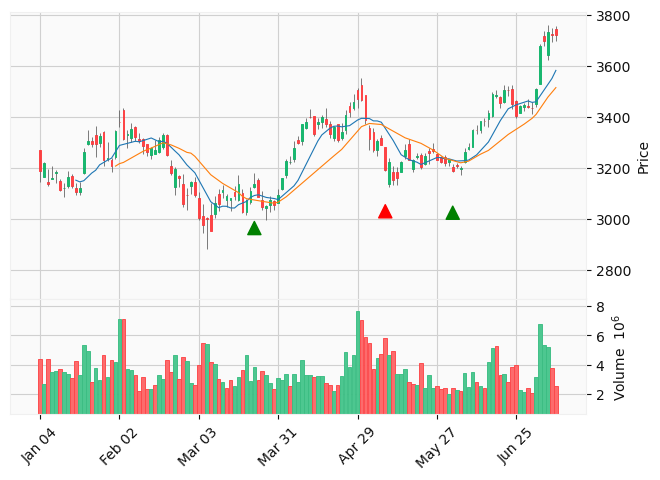

Total Profit/loss made using this strategy:  5.0 %


In [5]:
pnl_plot_data('AMZN')

#### Analysis
In this case, if the strategy was a little more responsive to the changes in price, it could have taken more advantage of the price increase that occured from the first buy point. The price had a lot of time to drop before a crossunder occured. The responsiveness of a moving average is propotional to the number of days the average is taken of. So for this scenario, a 5 day moving average against a 20 moving average may have yielded better profits. 

## Case study - Microsoft Corporation (MSFT)

Data taken from Yahoo website.


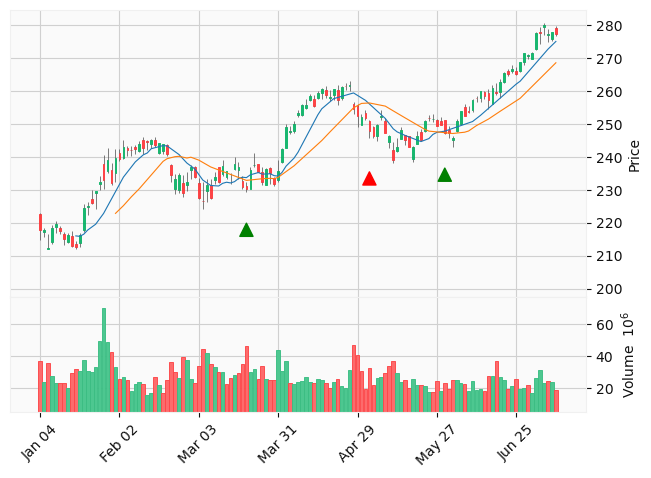

Total Profit/loss made using this strategy:  8.6 %


In [6]:
pnl_plot_data('MSFT')

#### Analysis
This case is similar to the Amazon chart, although the return on this chart is quite decent and the moving average period choice was good.

## Case study - S&P 500 (^GSPC)

Data taken from Yahoo website.


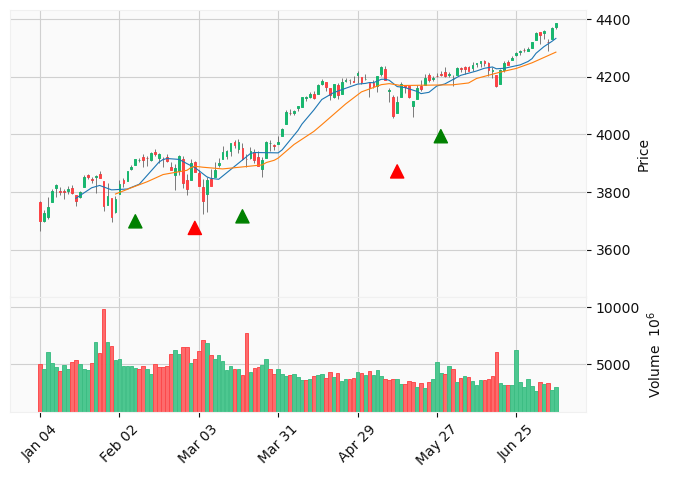

Total Profit/loss made using this strategy:  1.7 %


In [7]:
pnl_plot_data('^GSPC')

#### Analysis
In this scenario, the prices in the chart were initially moving sideways, with an incline that span almost 2 months. This strategy suffers from low yields in this scenario as the moving averages produces false signals, causing the system to make a buy order and follows with a sharp decline in the price movement. A profit was seen due to the incline that the chart displayed after the sideways movement.  

## Case study - Tesla, Inc. (TSLA)

Data taken from Yahoo website.


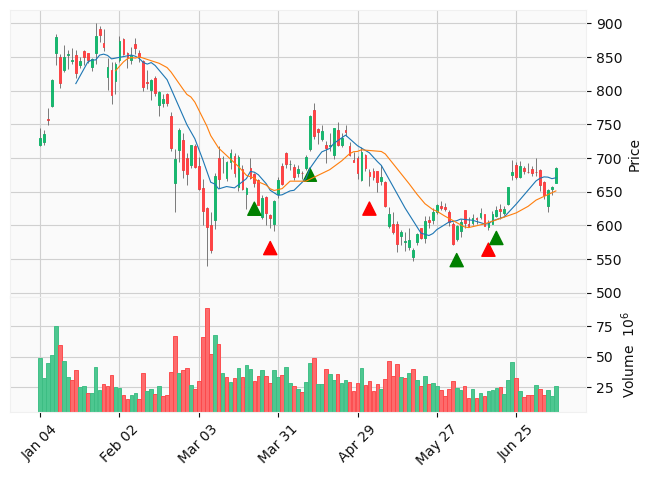

Total Profit/loss made using this strategy:  -3.9 %


In [8]:
pnl_plot_data('TSLA')

#### Analysis
This scenario would be an example of a down trending stock. The prices are seen to be steadily reducing with a few blips of price increases here and there. This strategy is seen to produce very poor results in terms of returns. To yield a positive return in a down-trending chart is very difficult even for a professional making buy/sell decisions. The software ends up making buy decisions somewhere a professional wouldn't because of those small blips. The hardcoded strategy does not recognise the overall shape of the price-movement. Therefore, it is fooled into making purchases that end in a loss.

## Conclusion
This method of executing successful trades is highly dependant on the type of graph/price-movements displayed on the chart, as observed from the five case studies. This strategy alone will not be able to promise big returns on every stock it has been implemented on. To come up with a success rate figure, a much larger sample size must be tested. At the start of this assignment I had stated that the choice of company stock data is completely random, however this would still cause skewed results to be produced. The strategy is very dependent on the type of industry the company is from, as it has a major role in the shape of the chart. so any sample size that has a higher number of industries that produce a positive price-moving chart will produce skewed/biased results. Therefore a sample size must only contain a certain type of industry.

More refinement and addition of more criteria would help this(as seen in the case studies), but as more criteria is hard coded into a system, the changing market environment and conditions may cause the strategies to become obselete, requiring a lot of work to keep them updated. This is where machine learning would come in. With a good machine learning algorithm, it can rewrite itself and learn the slightest observations that triggered a price increase in the market. It would be able to come up with a finely tailored strategy taken from learning historical data of stocks in different industries and produce promising results.

As for this code here, it can be used as a helping hand where the code is implemented to stocks deemed up-trending or promising by proffessionals to help streamline returns and the time spent on observing the market.